In [30]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

from AtlasCommonUtils import SetAtlasStyle
from ROOT import TLatex



rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)




#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

In [31]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [32]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [33]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
    scalar.append('isBKG')
    scalar.append('polarization')
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    
    scalar.append('x_e')
    scalar.append('y_e')
    scalar.append('Q2_e')
    
    scalar.append('vertex_z')
    scalar.append('ptratio')
    scalar.append('ptmiss')
    scalar.append('acoplanarity')
    scalar.append('Empz')
    scalar.append('njets')

    scalar.append('e_eta')
    scalar.append('e_rap')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('e_phi')
    scalar.append('gene_pt')
    
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    cols.append('jet_eta')
    cols.append('jet_phi')
    
    if(isMC):
        scalar.append('Weight')
        scalar.append('WeightGen')
        scalar.append('geny')
        scalar.append('gene_rap')

        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_eta')

        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')
        

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print ('\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds')
    return pd.concat([x for x in dataframes])

In [35]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
    temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [36]:
data_cut     = applyCutsJets(getJetData(['data_echeme.root']))
mc_cut = applyCutsJets(getJetData(['rapgap.root'],isMC=True),isMC=True)
altmc_cut= applyCutsJets(getJetData(['djangoh.root'],isMC=True),isMC=True)


 Processed data_echeme.root in 3.2 seconds
abs(vertex_z)<25 and and vertex_z!=0 111629  fraction kept: 90.0
0.2 < y < 0.7 66449  fraction kept: 59.5
Q2>150 66449  fraction kept: 100.0
e_pt >15 24440  fraction kept: 36.8
jet_pt>10 22125  fraction kept: 90.5
isBKG 19278  fraction kept: 87.1

 Processed rapgap.root in 38.9 seconds
abs(vertex_z)<25 and and vertex_z!=0 958520  fraction kept: 96.7
0.2 < y < 0.7 677816  fraction kept: 70.7
Q2>150 677816  fraction kept: 100.0
e_pt >15 294734  fraction kept: 43.5
jet_pt>10 263459  fraction kept: 89.4
isBKG 235608  fraction kept: 89.4

 Processed djangoh.root in 35.9 seconds
abs(vertex_z)<25 and and vertex_z!=0 920853  fraction kept: 96.6
0.2 < y < 0.7 650115  fraction kept: 70.6
Q2>150 650115  fraction kept: 100.0
e_pt >15 271425  fraction kept: 41.8
jet_pt>10 239917  fraction kept: 88.4
isBKG 214401  fraction kept: 89.4


### Define UniFold Algorithm


In [37]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Define features (input for the unfolding)

In [38]:
dphi_0_G = mc_cut[genvariable][:200000]
dphi_0_S =mc_cut[variable][:200000]
dphi_unknown_G = altmc_cut[genvariable][:200000]
dphi_unknown_S = altmc_cut[variable][:200000]

ept_0_G = mc_cut['gene_pt'][:200000]
ept_0_S =mc_cut['e_pt'][:200000]
ept_unknown_G = altmc_cut['gene_pt'][:200000]
ept_unknown_S = altmc_cut['e_pt'][:200000]

jetpt_0_G = mc_cut['genjet_pt'][:200000]
jetpt_0_S =mc_cut['jet_pt'][:200000]
jetpt_unknown_G = altmc_cut['genjet_pt'][:200000]
jetpt_unknown_S = altmc_cut['jet_pt'][:200000]

jeteta_0_G = mc_cut['genjet_eta'][:200000]
jeteta_0_S =mc_cut['jet_eta'][:200000]
jeteta_unknown_G = altmc_cut['genjet_eta'][:200000]
jeteta_unknown_S = altmc_cut['jet_eta'][:200000]

qt_0_G = mc_cut['genjet_qtnormjetpt'][:200000]
qt_0_S = mc_cut['jet_qtnormjetpt'][:200000]
qt_unknown_G = altmc_cut['genjet_qtnormjetpt'][:200000]
qt_unknown_S = altmc_cut['jet_qtnormjetpt'][:200000]

erap_0_G = mc_cut['gene_rap'][:200000]
erap_0_S = mc_cut['e_rap'][:200000]
erap_unknown_G = altmc_cut['gene_rap'][:200000]
erap_unknown_S = altmc_cut['e_rap'][:200000]

z_0_G = mc_cut['genjet_z'][:200000]
z_0_S = mc_cut['jet_z'][:200000]
z_unknown_G = altmc_cut['genjet_z'][:200000]
z_unknown_S = altmc_cut['jet_z'][:200000]


## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


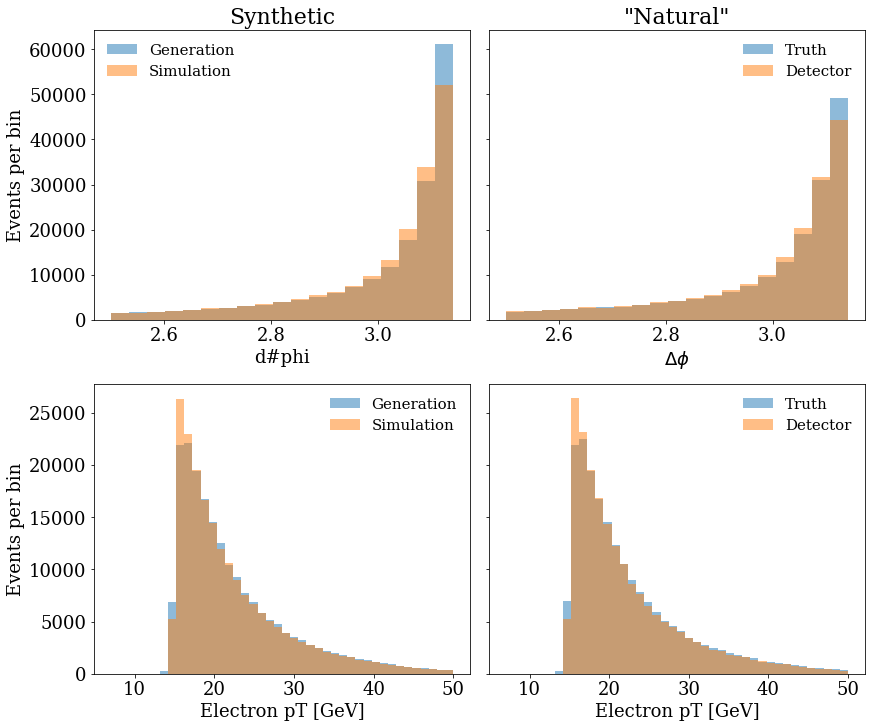

In [40]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(2.5, np.pi, 20)
## Define Multifold 
#bins = np.linspace(5, 50, 45)

ax[0, 0].set_title('Synthetic',fontsize=22)
ax[0, 0].set_xlabel(r'd#phi')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(dphi_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(dphi_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"',fontsize=22)
ax[0, 1].set_xlabel(namevariable)
hG1, _, _ = ax[0, 1].hist(dphi_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(dphi_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')






bins = np.linspace(7, 50, 43)

ax[1, 0].set_xlabel('Electron pT [GeV]')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(ept_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(ept_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Electron pT [GeV]')
hG1, _, _ = ax[1, 1].hist(ept_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(ept_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center',fontsize=32)

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

## Define Multifold 

In [51]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    
    #theta0_G = np.stack(theta0_G, axis=1)
    #theta0_S = np.stack(theta0_S, axis=1)
    #theta_unknown_S = np.stack(theta_unknown_S, axis=1)
    #labels0 = np.zeros(len(theta0_G))
    #labels1 = np.zeros(len(theta0_G))
    #labels_unknown = np.ones(len(theta_unknown_S))
    #xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    #yvals_1 = np.concatenate((labels0, labels_unknown))
    #xvals_2 = np.concatenate((theta0_G, theta0_G))
    #yvals_2 = np.concatenate((labels0, labels1))
    
    

    
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull

    return weights, model

## Unfold two variables simultaneously

In [ ]:
K.clear_session()

In [42]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G / 100., ept_0_G / 100.),
                       theta0_S=(dphi_0_S / 100., ept_0_S / 100.),
                       theta_unknown_S=(dphi_unknown_S / 100.,
                                        ept_unknown_S / 100.))


ITERATION: 1

STEP 1

Epoch 1/200
30/30 [==============================] - 9s 290ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accur

30/30 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5240 - val_loss: 0.6914 - val_accuracy: 0.5232
Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5239 - val_loss: 0.6918 - val_accuracy: 0.5212
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5215 - val_loss: 0.6915 - val_accuracy: 0.5207
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5228 - val_loss: 0.6916 - val_accuracy: 0.5256
Epoch 62/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5242 - val_loss: 0.6914 - val_accuracy: 0.5226
Epoch 63/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5242 - val_loss: 0.6914 - val_accuracy: 0.5224
Epoch 64/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5239 - val_loss: 0.6915 - val_accuracy: 0.5256
Epoch 65/200
30/30 

30/30 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.4997 - val_loss: 0.6924 - val_accuracy: 0.4995
Epoch 29/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5006 - val_loss: 0.6918 - val_accuracy: 0.4995
Epoch 00029: early stopping

ITERATION: 2

STEP 1

Epoch 1/200
30/30 [==============================] - 10s 319ms/step - loss: 0.6925 - accuracy: 0.5137 - val_loss: 0.6918 - val_accuracy: 0.5180
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5208 - val_loss: 0.6918 - val_accuracy: 0.5213
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5194 - val_loss: 0.6917 - val_accuracy: 0.5232
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5172 - val_loss: 0.6917 - val_accuracy: 0.5242
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5199 - val_loss: 

30/30 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5037 - val_loss: 0.6896 - val_accuracy: 0.5187
Epoch 12/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5046 - val_loss: 0.6895 - val_accuracy: 0.4975
Epoch 13/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5050 - val_loss: 0.6895 - val_accuracy: 0.5112
Epoch 14/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5085 - val_loss: 0.6896 - val_accuracy: 0.5164
Epoch 15/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5131 - val_loss: 0.6895 - val_accuracy: 0.4964
Epoch 00015: early stopping

STEP 2

Epoch 1/200
30/30 [==============================] - 9s 302ms/step - loss: 0.6908 - accuracy: 0.5014 - val_loss: 0.6907 - val_accuracy: 0.4978
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5008 - val_loss: 0.6907 - val

30/30 [==============================] - 0s 6ms/step - loss: 0.6973 - accuracy: 0.5010 - val_loss: 0.6974 - val_accuracy: 0.4991
Epoch 22/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 0.6976 - val_accuracy: 0.4997
Epoch 23/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6973 - accuracy: 0.5008 - val_loss: 0.6972 - val_accuracy: 0.4994
Epoch 00023: early stopping


ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


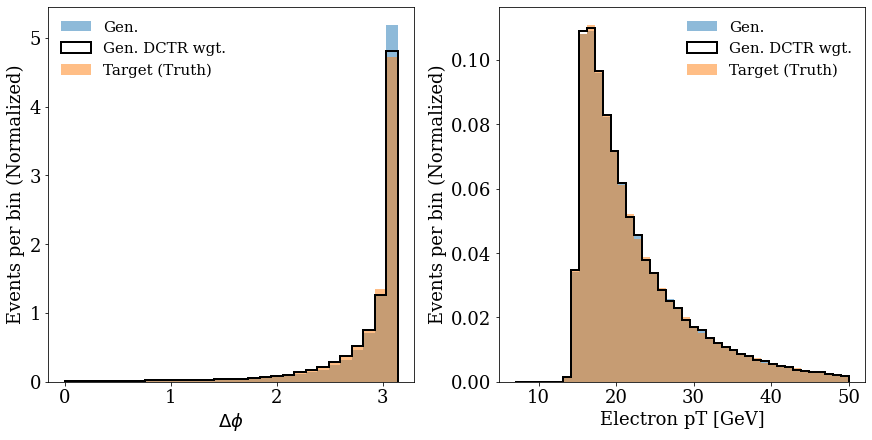

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


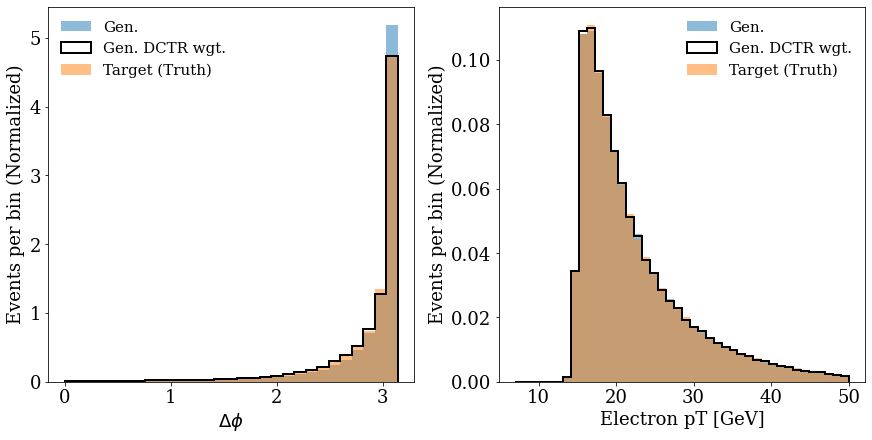

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


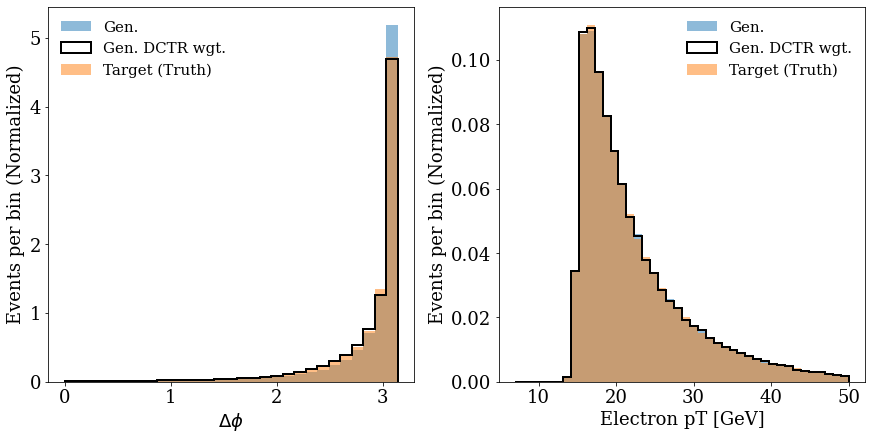

ITERATION: 4


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


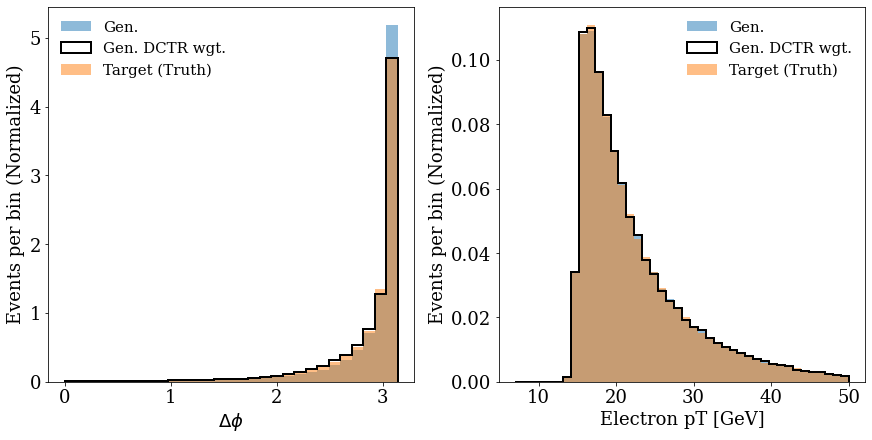

In [43]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 30)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel(namevariable)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(7, 50, 43)

    ax[1].set_xlabel('Electron pT [GeV]')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## 6D

In [49]:
K.clear_session()

In [52]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=4,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
30/30 [==============================] - 9s 306ms/step - loss: 0.6915 - accuracy: 0.5260 - val_loss: 0.6908 - val_accuracy: 0.5300
Epoch 2/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5303 - val_loss: 0.6904 - val_accuracy: 0.5310
Epoch 3/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5313 - val_loss: 0.6903 - val_accuracy: 0.5315
Epoch 4/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5308 - val_loss: 0.6902 - val_accuracy: 0.5306
Epoch 5/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5311 - val_loss: 0.6900 - val_accuracy: 0.5326
Epoch 6/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5310 - val_loss: 0.6900 - val_accuracy: 0.5328
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5312 - val_loss: 0.6900 - val_accur

30/30 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5009 - val_loss: 0.6871 - val_accuracy: 0.4969
Epoch 11/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5003 - val_loss: 0.6870 - val_accuracy: 0.4974
Epoch 12/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.5013 - val_loss: 0.6871 - val_accuracy: 0.4972
Epoch 13/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.5012 - val_loss: 0.6870 - val_accuracy: 0.4969
Epoch 14/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5011 - val_loss: 0.6870 - val_accuracy: 0.4961
Epoch 15/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5008 - val_loss: 0.6872 - val_accuracy: 0.4962
Epoch 00015: early stopping

ITERATION: 2

STEP 1

Epoch 1/200
30/30 [==============================] - 9s 310ms/step - loss: 0.6914 - accuracy: 0.5284 - val_los

30/30 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5309 - val_loss: 0.6911 - val_accuracy: 0.5195
Epoch 00051: early stopping

STEP 2

Epoch 1/200
30/30 [==============================] - 9s 314ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.4991
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5004 - val_loss: 0.6909 - val_accuracy: 0.4986
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5001 - val_loss: 0.6909 - val_accuracy: 0.4978
Epoch 4/200
30/30 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5005 - val_loss: 0.6911 - val_accuracy: 0.4976
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5004 - val_loss: 0.6910 - val_accuracy: 0.4980
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.4999 - val_loss: 0.6909 - val_acc

Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5118 - val_loss: 0.6971 - val_accuracy: 0.5131
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.5132 - val_loss: 0.6971 - val_accuracy: 0.5123
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5116 - val_loss: 0.6971 - val_accuracy: 0.5144
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.5129 - val_loss: 0.6972 - val_accuracy: 0.5241
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.5135 - val_loss: 0.6972 - val_accuracy: 0.5146
Epoch 11/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.5144 - val_loss: 0.6970 - val_accuracy: 0.5202
Epoch 12/200
30/30 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.5126 - val_loss: 0.6971 - val_accuracy: 0.5172
Epoch 13/2

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


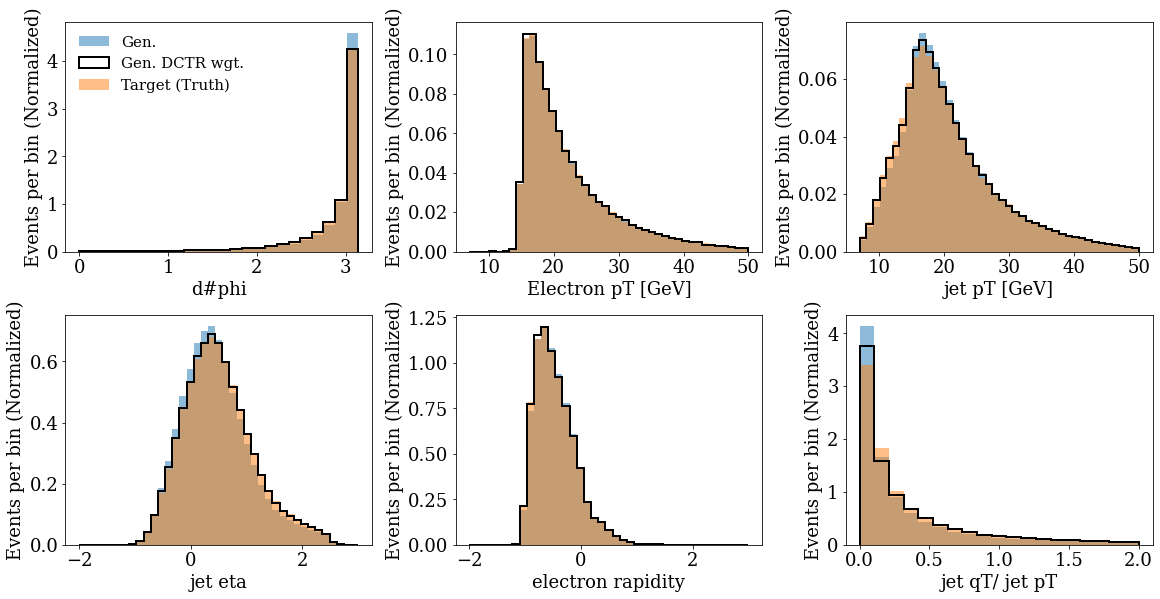

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


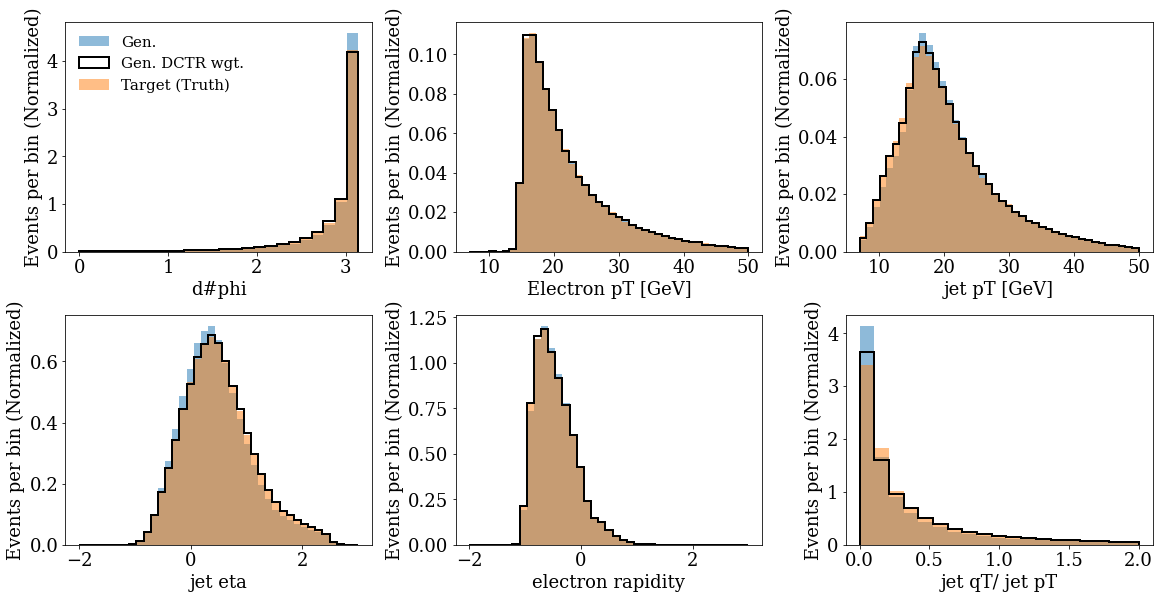

ITERATION: 3


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


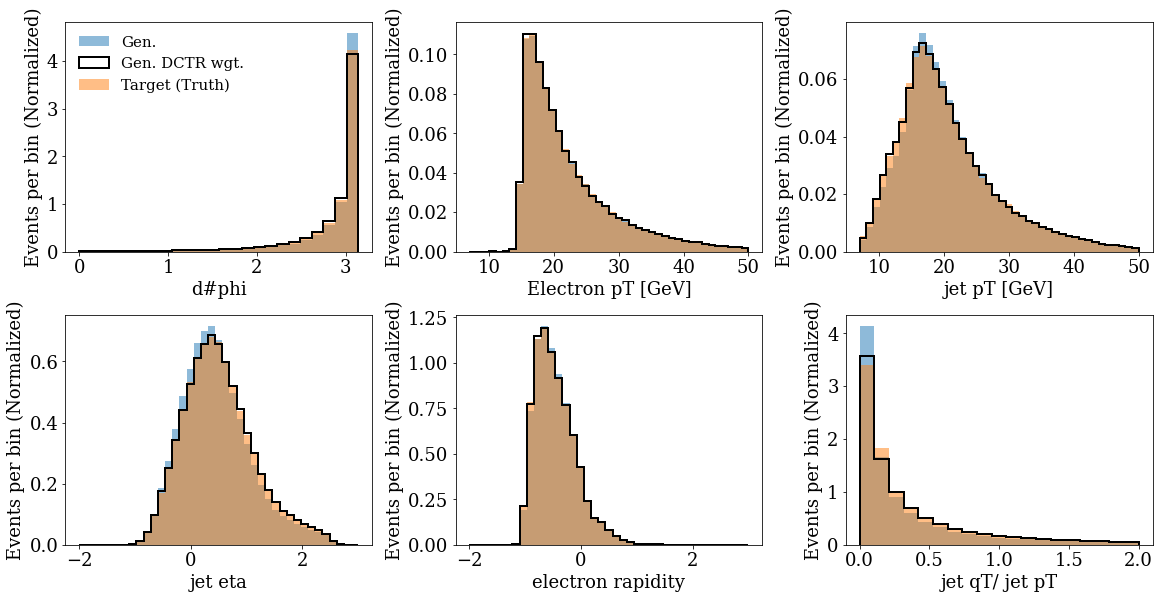

ITERATION: 4


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


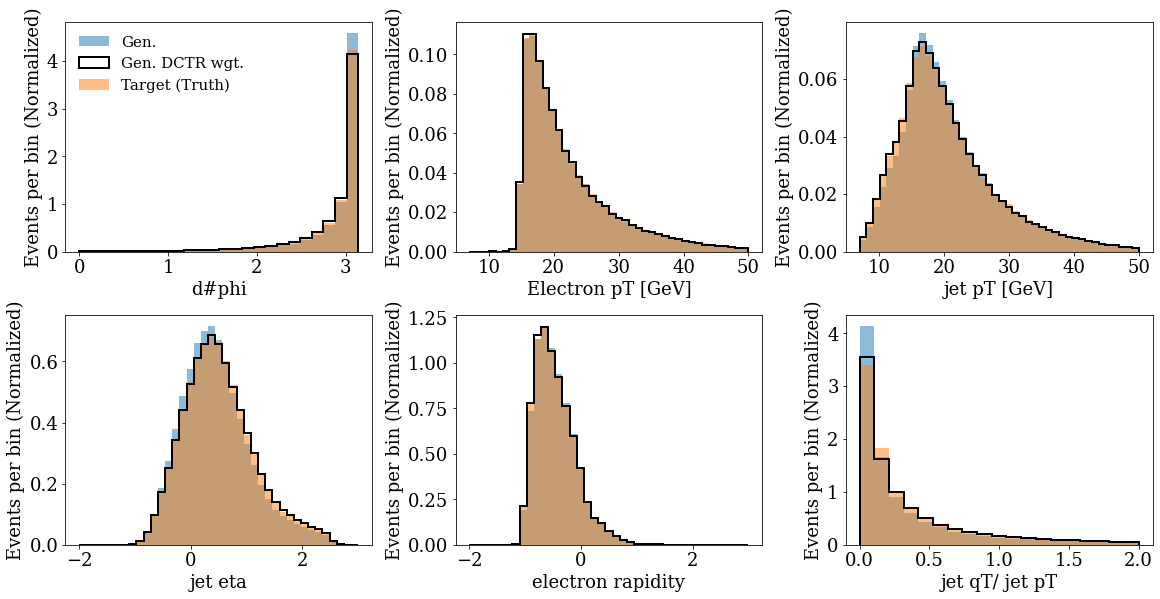

In [56]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 25)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel(r'd#phi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(7, 50, 43)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(7, 50, 43)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 20)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    


    
    
    
    fig.show()
    plt.show()